In [2]:
import argparse
import numpy as np
import pickle
import time
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime


from dataset import get_dataloader
from tqdm import tqdm
import random
from models.gated_tpp import *
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

## Kernel Predictions

In [4]:
data = '../data/simulated/sin_hawkes/'
batch_size = 1
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data, 1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)

t_max = max(max(max(valloader.dataset.time)), max(max(testloader.dataset.time)), max(max(trainloader.dataset.time)))

model = gated_TPP(num_types,32, t_max=t_max,dropout= 0.1)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/power_hawkesdebug_model.pt'))

<All keys matched successfully>

In [7]:
kernel_values = []
all_times = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

(0, 10)

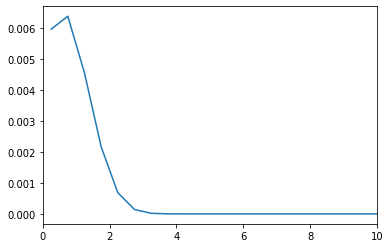

In [8]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


## Moving Average

step = 0.5

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())
alpha = np.array(alpha)
# alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
plt.plot(t,alpha)
plt.xlim(0, 10)

## Event Predictions

### RMSE Calculations

In [9]:
last_errors = []
all_errors = []
all_predictions = []
all_arrivals = []
for batch in testloader:
    

    event_type = batch[2]
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)

    
    predicted_times = model(event_type,event_time)


    last_event_index = event_type.sum(-1)-2
    errors = predicted_times[:, :-1] - arrival_time[:, 1:]
    seq_index = 0
    for idx in last_event_index:
        last_errors.append(errors[seq_index][idx].unsqueeze(-1))
        all_errors.append(errors[seq_index][:idx+1])
        all_predictions.append(predicted_times[:, :-1][:idx+1].squeeze(0))
        all_arrivals.append(arrival_time[:, :-1][:idx+1].squeeze(0))
last_errors = torch.cat(last_errors)
last_RMSE =(last_errors**2).mean().sqrt()

all_predictions = torch.cat(all_predictions)
all_arrivals = torch.cat(all_arrivals)


all_errors = torch.cat(all_errors)
all_RMSE = (all_errors**2).mean().sqrt()



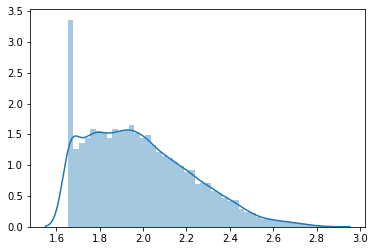

In [10]:
sns.distplot(all_predictions.cpu().detach())

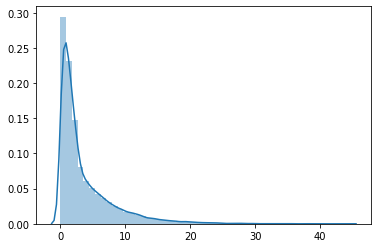

In [11]:
sns.distplot(all_arrivals.cpu().detach())

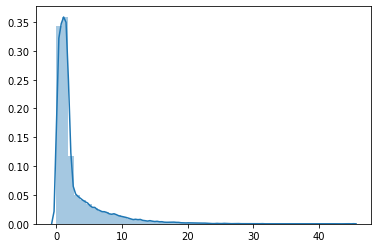

In [12]:
sns.distplot(np.abs(all_errors.to('cpu').detach()))

## Gate Experiments

In [16]:
model.encoder.kernel.get_params()
# model.encoder.sigmoid.get_params()

{'length_scale': tensor(1.0881, device='cuda:0', grad_fn=<SoftplusBackward>),
 'sigma': 1,
 'Norm-P': 1}

In [15]:

def squared_exponential_kernel(x, sigma=10, lambd=0.01, norm=2):
    d = x ** norm

    return (sigma ** 2) * torch.exp(-(d ** 2) / lambd ** 2)


def sigmoid(x,l=0.1,s=0.1,b = 0.1,norm =2):
    d = x**norm
    return 1+torch.tanh((d-l)/s)



(0, 10)

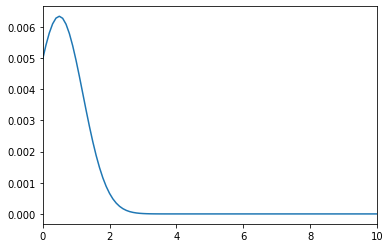

In [41]:
t =torch.arange(0,200,0.1)
val = squared_exponential_kernel(t,sigma = 1,lambd=1.0,norm = 1)
val_s = sigmoid((t/200),l =0.03,s = 0.01,norm =1)


plt.plot(t,(val_s)*val)
plt.xlim(0, 10)




In [ ]:
(tensor(0.2037, grad_fn=<SelectBackward>),
 tensor(0.6250, grad_fn=<SelectBackward>))

In [ ]:
nn.ModuleList([nn.Parameter(),nn.Parameter()])

In [ ]:
nn.Parameter()

In [ ]:
nn.Parameter(torch.tensor(-0.1))

In [ ]:
nn.Sequential(nn.Parameter(torch.tensor([ 0.1] )), nn.Softplus())

In [ ]:
torch.softplus

In [34]:
data = '../data/simulated/power_hawkes/'
batch_size = 1
def load_data(name, dict_name):
    with open(name, 'rb') as f:
        data = pickle.load(f, encoding='latin-1')
        num_types = data['dim_process']
        data = data[dict_name]
        return data, int(num_types)

train_data, num_types = load_data(data + 'train.pkl', 'train')
dev_data, _ = load_data(data + 'dev.pkl', 'dev')
test_data, _ = load_data(data + 'test.pkl', 'test')


trainloader = get_dataloader(train_data, batch_size, shuffle=True)
testloader = get_dataloader(test_data, 1, shuffle=False)
valloader = get_dataloader(dev_data, 1, shuffle=False)

t_max = max(max(max(valloader.dataset.time)), max(max(testloader.dataset.time)), max(max(trainloader.dataset.time)))

model = gated_TPP(num_types,32, t_max=t_max,dropout= 0.1)
device = 'cuda'
model.load_state_dict(torch.load('trained_models/power_hawkesdebug_model.pt'))

<All keys matched successfully>

In [37]:
print(model.encoder.kernel.get_params())
print(model.encoder.sigmoid.get_params())

{'length_scale': tensor(1.2644, grad_fn=<SoftplusBackward>), 'sigma': 1, 'Norm-P': 1}
(tensor(0.5250, grad_fn=<SelectBackward>), tensor(0.5250, grad_fn=<SelectBackward>))


In [38]:
kernel_values = []
all_times = []

model = model.to(device)

for batch in testloader:
    
    event_type = batch[2]
    length = event_type.sum()
    event_time = batch[0]
    arrival_time = batch[1]
    
    event_time, arrival_time, event_type,_ = map(lambda x: x.to(device), batch)
    scores, embedding,t_diff = model.encoder(event_type,event_time)


    masked_t_diff = (t_diff[0][:length,:length])
    masked_scores = (scores[0][:length,:length])
    row,column = masked_t_diff.size()
    row,column = torch.tril_indices(row,column)
    times = masked_t_diff[row,column]
    triggering_values=  masked_scores[row,column]
    
    kernel_values.append(triggering_values.detach())
    all_times.append(times.detach())
    
kernel_values = torch.cat(kernel_values)
all_times = torch.cat(all_times)

(0, 10)

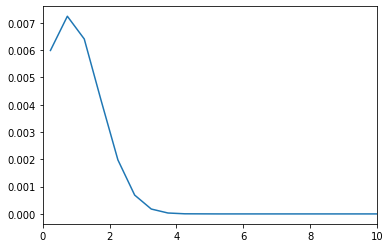

In [39]:
x = all_times.detach()
y = kernel_values.detach()

sorted_indices = torch.argsort(x)

x = x[sorted_indices]
y = y[sorted_indices]


## Moving Average

step = 0.5

t = []
alpha = []

for i in np.arange(step,200,step):
    avg_index = (x<i) & ( x >i - step)
    t.append(x[avg_index].mean().item())
    alpha.append(y[avg_index].mean().item())
alpha = np.array(alpha)
# alpha = (alpha - alpha.min())/(alpha.max()-alpha.min())
plt.plot(t,alpha)
plt.xlim(0, 10)